# **Check enviroment**

Set data_path to make notebooks works well both on local and google drive.

In [24]:
import sys
import os
data_path = ''
# Check if the environment is Google Colab
if 'google.colab' in sys.modules:
    print("Running on Google Colab")
    # Install required libraries
    !pip install tensorflow -q
    !pip install keras -q
    !pip install scikit-learn -q
    !pip install pandas -q
    !pip install numpy -q
    !pip install matplotlib -q
    !pip install umap-learn -q
    !pip install lightgbm
    !pip install xgboost

    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    # set the path where the csv file stored in your own google drive. 
    data_path = '/content/drive/MyDrive/Heartbeat_Project/'
    
else:
    print("Running on local environment")

    current_path = os.getcwd()
    print("Current working directory:", current_path)
    data_path = '../data/raw/'

Path = dict({
    'ptbdb_normal': data_path +  'ptbdb_normal.csv',
    'ptbdb_abnormal':  data_path + 'ptbdb_abnormal.csv',
})

Running on local environment
Current working directory: g:\Meine Ablage\heartbeat-analysis-ai\notebooks


# **Import packages:**

In [97]:
# Verify installation and import libraries
import tensorflow as tf
import keras
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
from matplotlib.colors import ListedColormap
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedRandomForestClassifier



In [25]:
def addColumnsToDataframe(df):
    """
    As the dataset is composed with 188 columns with the 188th columns as the category values,
    so we give the last column the name 'target', others named with 'c_182'
    """
    num_columns= df.shape[1]
    feature_col_name = ['c_' + str(i) for i in range(0, num_columns - 1)]
    df_columns = feature_col_name + ['target']
    df.columns = df_columns
    return df

def convertColumnAsInt(df, column):
    """
    As the category value is in float type. We want to get the int to identify the category.
    """
    df[column] = df[column].astype(int)
    return df

def getBarChartFromCategoryValueCounts(category_value_counts):
    """
    We call the plot over the pandas series object to plot the category count values
    """
    plt.figure(figsize=(10, 6))
    bar_chart = category_value_counts.plot(kind='bar')
    plt.xlabel('Categories')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(False)
    plt.xticks(rotation=360)
    for i in bar_chart.containers:
        bar_chart.bar_label(i, label_type='edge')
    plt.show()


def showTop10DataInChart(df):
    plt.figure(figsize=(10, 6))
    xDataAxis = list(range(0, df.shape[1]))
    yDataRows = list(df.values[1: 10])
    for y in yDataRows:
        plt.plot(xDataAxis, y)
    plt.show()

In [26]:
ptbdb_normal = pd.read_csv(Path.get('ptbdb_normal'), header=None ) 
ptbdb_normal_with_columns = addColumnsToDataframe(ptbdb_normal) # add columns to the dataframe
ptbdb_normal_with_columns = convertColumnAsInt(ptbdb_normal_with_columns, 'target') # convert the target column to int

In [27]:
ptbdb_normal_with_columns # Normal in target = 0 !!!!

,c_0,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,...,c_178,c_179,c_180,c_181,c_182,c_183,c_184,c_185,c_186,target
0,1.000000,0.900324,0.358590,0.051459,0.046596,0.126823,0.133306,0.119125,0.110616,0.113047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.048774,0.054478,0.041643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,1.000000,0.867238,0.201360,0.099349,0.141336,0.120934,0.108516,0.096393,0.093436,0.100828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4041,1.000000,0.929586,0.503550,0.293491,0.169822,0.159763,0.130769,0.125444,0.137278,0.111243,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4042,1.000000,0.637579,0.154837,0.061983,0.088965,0.083374,0.065143,0.057365,0.060039,0.060039,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4043,1.000000,0.872574,0.465071,0.232212,0.126132,0.155886,0.174644,0.190168,0.203752,0.168823,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4044,0.915983,0.529373,0.288406,0.144536,0.171802,0.180669,0.177566,0.176458,0.178896,0.180448,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [28]:
ptbdb_abnormal = pd.read_csv(Path.get('ptbdb_abnormal'), header=None ) 
ptbdb_abnormal_with_columns = addColumnsToDataframe(ptbdb_abnormal) # add columns to the dataframe
ptbdb_abnormal_with_columns = convertColumnAsInt(ptbdb_abnormal_with_columns, 'target') # convert the target column to int

In [29]:
ptbdb_abnormal_with_columns ## Abnormal in target = 1 !!!!

,c_0,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,...,c_178,c_179,c_180,c_181,c_182,c_183,c_184,c_185,c_186,target
0,0.932233,0.869679,0.886186,0.929626,0.908775,0.933970,0.801043,0.749783,0.687229,0.635100,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,1.000000,0.606941,0.384181,0.254237,0.223567,0.276836,0.253430,0.184826,0.153349,0.121872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,1.000000,0.951613,0.923963,0.853303,0.791859,0.734255,0.672043,0.685100,0.670507,0.667435,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.977819,0.899261,0.230129,0.032348,0.142329,0.223660,0.328096,0.367837,0.381701,0.389094,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.935618,0.801661,0.805815,1.000000,0.722741,0.480789,0.454829,0.319834,0.266874,0.308411,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10501,0.981409,1.000000,0.559171,0.287093,0.196639,0.204862,0.215946,0.243833,0.242760,0.250268,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
10502,0.906250,0.922379,0.878024,0.810484,0.712702,0.667339,0.608871,0.527218,0.480847,0.442540,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
10503,1.000000,0.867971,0.674122,0.470332,0.296987,0.169307,0.077664,0.081392,0.074868,0.089779,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
10504,1.000000,0.984672,0.658888,0.556394,0.446809,0.395790,0.315260,0.276367,0.261039,0.258522,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


Merge normal and abnomal data to one dataset and shuffle it

In [30]:
#Merge the datasets
ptbdb = pd.concat([ptbdb_abnormal_with_columns, ptbdb_normal_with_columns], ignore_index=True) # ingore the index to make the index continuous
#Shuffle the dataset
ptbdb = ptbdb.sample(frac=1).reset_index(drop=True)
ptbdb

,c_0,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,...,c_178,c_179,c_180,c_181,c_182,c_183,c_184,c_185,c_186,target
0,0.993048,0.857860,0.605639,0.408652,0.277327,0.124759,0.067594,0.066435,0.078022,0.097721,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,1.000000,0.751100,0.478191,0.274910,0.000000,0.015206,0.060824,0.141256,0.295318,0.462985,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,1.000000,0.633241,0.190028,0.001662,0.110249,0.194460,0.227147,0.232133,0.235457,0.243213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,1.000000,0.580675,0.089790,0.000000,0.139015,0.082042,0.096171,0.071103,0.051504,0.087967,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.995005,0.642358,0.203796,0.000999,0.159840,0.189810,0.106893,0.106893,0.134865,0.096903,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14547,0.920259,0.924928,0.700431,0.368534,0.122845,0.000000,0.050287,0.114224,0.104167,0.103448,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
14548,1.000000,0.606548,0.383532,0.176389,0.164683,0.188690,0.187500,0.180357,0.182143,0.180159,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
14549,0.995828,1.000000,0.916551,0.853964,0.716273,0.568846,0.534075,0.420028,0.371349,0.275382,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
14550,0.983436,0.982209,0.866871,0.823313,0.777301,0.699386,0.671166,0.668712,0.646012,0.651534,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [31]:
#Split the data into training (80%) and testing (20%)
from sklearn.model_selection import train_test_split
ptbdb_train, ptbdb_test = train_test_split(ptbdb, test_size=0.2, random_state=42)


In [32]:
#train:
print(ptbdb_train.shape)
print("The train data has 11.641 and 188 columns.")

#test:
print(ptbdb_test.shape)
print("The test data has 2.911 and 188 columns.")

(11641, 188)
The train data has 11.641 and 188 columns.
(2911, 188)
The test data has 2.911 and 188 columns.


In [33]:
print(ptbdb_train["target"])
print(ptbdb_test["target"])

4292     1
8963     1
10671    1
8994     1
13691    1
        ..
5191     0
13418    1
5390     1
860      1
7270     1
Name: target, Length: 11641, dtype: int32
2069     1
6174     1
11676    1
5407     1
11090    1
        ..
12476    1
11461    0
11360    1
3958     0
5440     1
Name: target, Length: 2911, dtype: int32


In [34]:
print(ptbdb_train.dtypes)
print(ptbdb_test.dtypes)
print("The features are numeric. All columns have the type float64, while the target column is int32.")

c_0       float64
c_1       float64
c_2       float64
c_3       float64
c_4       float64
           ...   
c_183     float64
c_184     float64
c_185     float64
c_186     float64
target      int32
Length: 188, dtype: object
c_0       float64
c_1       float64
c_2       float64
c_3       float64
c_4       float64
           ...   
c_183     float64
c_184     float64
c_185     float64
c_186     float64
target      int32
Length: 188, dtype: object
The features are numeric. All columns have the type float64, while the target column is int32.


In [35]:
print(ptbdb_test.info(show_counts=True), end="\n\n")
print("Size of the DataFrame", ptbdb_test.shape, end='\n\n')

print(ptbdb_train.info(show_counts=True), end="\n\n")
print("Size of the DataFrame", ptbdb_train.shape, end='\n\n')

<class 'pandas.core.frame.DataFrame'>
Index: 2911 entries, 2069 to 5440
Columns: 188 entries, c_0 to target
dtypes: float64(187), int32(1)
memory usage: 4.2 MB
None

Size of the DataFrame (2911, 188)

<class 'pandas.core.frame.DataFrame'>
Index: 11641 entries, 4292 to 7270
Columns: 188 entries, c_0 to target
dtypes: float64(187), int32(1)
memory usage: 16.7 MB
None

Size of the DataFrame (11641, 188)



Remove duplicates

In [36]:
nb_rows_duplicated = ptbdb_train.duplicated().sum()
print("Number of rows duplicated :", nb_rows_duplicated)

nb_rows_duplicated = ptbdb_test.duplicated().sum()
print("Number of rows duplicated :", nb_rows_duplicated)

Number of rows duplicated : 3
Number of rows duplicated : 1


In [37]:
# Remove duplicates from the training set
ptbdb_train = ptbdb_train.drop_duplicates()

# Remove duplicates from the testing set
ptbdb_test = ptbdb_test.drop_duplicates()

# Verify the removal by checking the number of duplicated rows again
nb_rows_duplicated_train = ptbdb_train.duplicated().sum()
print("Number of rows duplicated in train set after removal:", nb_rows_duplicated_train)

nb_rows_duplicated_test = ptbdb_test.duplicated().sum()
print("Number of rows duplicated in test set after removal:", nb_rows_duplicated_test)


Number of rows duplicated in train set after removal: 0
Number of rows duplicated in test set after removal: 0


In [38]:
print("Missing values in train:", ptbdb_train.isnull().sum())
print("Missing values in test:", ptbdb_test.isnull().sum())
print("The data has no missing values.")

Missing values in train: c_0       0
c_1       0
c_2       0
c_3       0
c_4       0
         ..
c_183     0
c_184     0
c_185     0
c_186     0
target    0
Length: 188, dtype: int64
Missing values in test: c_0       0
c_1       0
c_2       0
c_3       0
c_4       0
         ..
c_183     0
c_184     0
c_185     0
c_186     0
target    0
Length: 188, dtype: int64
The data has no missing values.


In [42]:
ptbdb_train.head(100)

,c_0,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,...,c_178,c_179,c_180,c_181,c_182,c_183,c_184,c_185,c_186,target
4292,0.959212,1.000000,0.793249,0.441163,0.304735,0.223160,0.185654,0.156118,0.150492,0.142522,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
8963,0.946755,1.000000,0.976705,0.900166,0.758735,0.600666,0.475874,0.377704,0.266223,0.227953,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
10671,0.970902,0.563003,0.057937,0.028059,0.049883,0.071967,0.068589,0.071707,0.070668,0.066511,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
8994,1.000000,0.715696,0.442308,0.364865,0.256757,0.081601,0.036383,0.012994,0.031705,0.002079,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
13691,0.988818,1.000000,0.899361,0.837061,0.757188,0.549521,0.507987,0.413738,0.370607,0.343450,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5748,1.000000,0.855734,0.597856,0.507610,0.425509,0.382851,0.327760,0.292390,0.284887,0.271168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
7302,1.000000,0.981818,0.817273,0.722727,0.633636,0.607273,0.506364,0.432727,0.347273,0.295455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
9085,0.950100,1.000000,0.638723,0.231537,0.000000,0.139721,0.292748,0.327345,0.345975,0.368596,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
14041,0.924389,0.843246,0.341632,0.018903,0.038266,0.082988,0.070539,0.057169,0.056247,0.040111,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [43]:
ptbdb_test.head(100)

,c_0,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,...,c_178,c_179,c_180,c_181,c_182,c_183,c_184,c_185,c_186,target
2069,1.000000,0.901742,0.789547,0.697561,0.601394,0.625784,0.579791,0.615331,0.595122,0.603484,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
6174,1.000000,0.844671,0.304989,0.099773,0.287982,0.396825,0.462585,0.470522,0.462585,0.486395,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
11676,0.948387,0.828674,0.594624,0.204659,0.093907,0.106810,0.174552,0.265233,0.292115,0.285663,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
5407,1.000000,0.578744,0.166184,0.002899,0.085024,0.124638,0.147826,0.157488,0.154106,0.173430,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
11090,1.000000,0.619108,0.339490,0.157962,0.080255,0.102548,0.110191,0.107643,0.128025,0.101911,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10875,1.000000,0.000000,0.722094,0.345650,0.222479,0.205543,0.122402,0.085450,0.089299,0.046959,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
9267,0.995152,1.000000,0.650508,0.542705,0.438827,0.383195,0.292936,0.257156,0.228763,0.225531,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
10170,0.935414,0.556783,0.218727,0.114766,0.122929,0.098920,0.073709,0.066026,0.061945,0.063866,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
14408,0.991597,0.947059,0.632773,0.339496,0.261345,0.210924,0.210924,0.205042,0.165546,0.118487,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


Visualize Target 

In [44]:
# Define mapping dictionary
class_mapping = {
    1: 'Normal',
    0: 'Abnormal'
}

# Define custom colors for each category
color_mapping = {
    0: 'green',    # Normal beat
    1: 'red',      # Abnormal beat 
}

classes_to_plot = [0, 1]

# Calculate value counts based on mapped class names
value_counts_series_train = ptbdb_train['target'].map(class_mapping).value_counts()
# Calculate value counts based on mapped class names
value_counts_series_test = ptbdb_test['target'].map(class_mapping).value_counts()

In [45]:
print("Training Dataset Class Distribution:")
print(value_counts_series_train)

print("\nTesting Dataset Class Distribution:")
print(value_counts_series_test)

Training Dataset Class Distribution:
target
Normal      8386
Abnormal    3252
Name: count, dtype: int64

Testing Dataset Class Distribution:
target
Normal      2116
Abnormal     794
Name: count, dtype: int64


Barplots and Piecharts

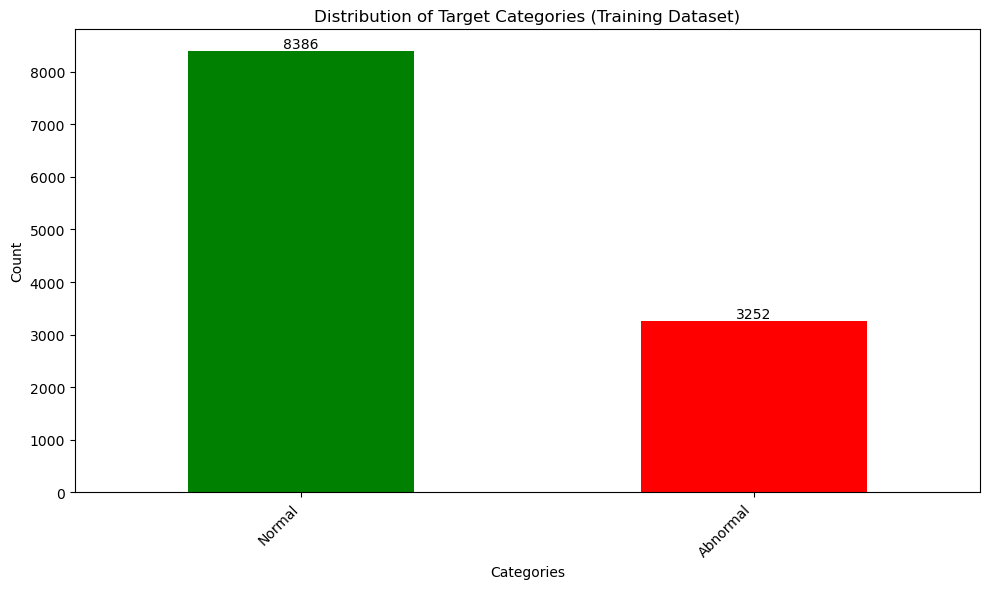

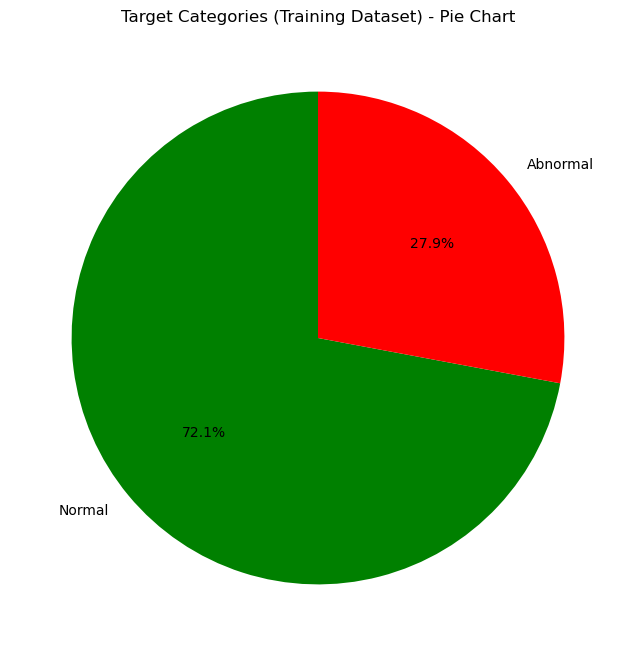

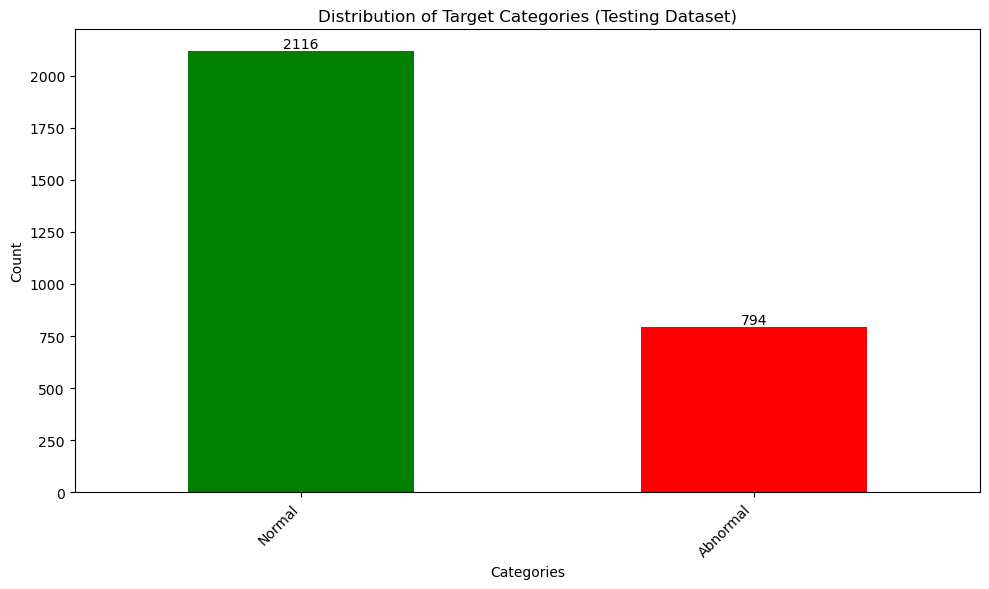

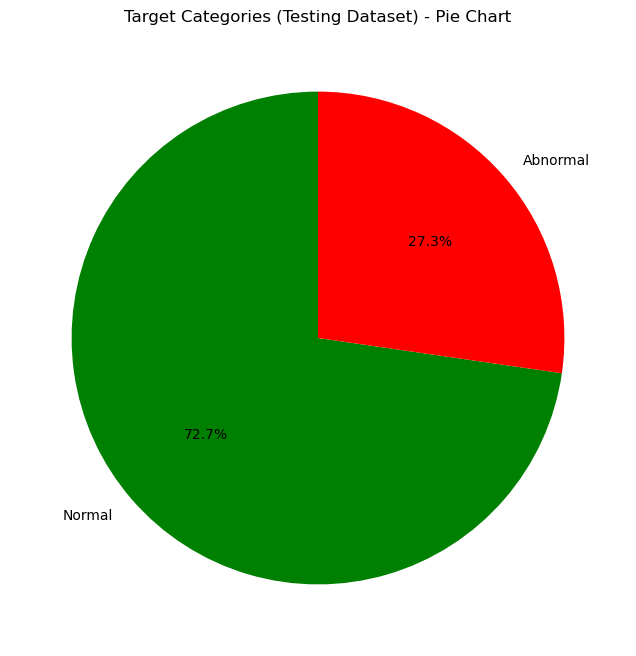

In [46]:
import matplotlib.pyplot as plt

# Bar chart for the training dataset
plt.figure(figsize=(10, 6))
bar_chart_train = value_counts_series_train.plot(kind='bar', color=color_mapping.values())
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Distribution of Target Categories (Training Dataset)')
plt.xticks(rotation=45, ha='right')

# Add labels to the bars in the training set
for container in bar_chart_train.containers:
    plt.bar_label(container, label_type='edge')

plt.tight_layout()
plt.show()

# Pie chart for the training dataset
plt.figure(figsize=(8, 8))  # Set figure size
value_counts_series_train.plot(kind='pie', autopct='%1.1f%%', colors=color_mapping.values(), startangle=90)
plt.ylabel('')  # Remove the y-label
plt.title('Target Categories (Training Dataset) - Pie Chart')
plt.show()

# Bar chart for the testing dataset
plt.figure(figsize=(10, 6))
bar_chart_test = value_counts_series_test.plot(kind='bar', color=color_mapping.values())
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Distribution of Target Categories (Testing Dataset)')
plt.xticks(rotation=45, ha='right')

# Add labels to the bars in the testing set
for container in bar_chart_test.containers:
    plt.bar_label(container, label_type='edge')

plt.tight_layout()
plt.show()

# Pie chart for the testing dataset
plt.figure(figsize=(8, 8))  # Set figure size
value_counts_series_test.plot(kind='pie', autopct='%1.1f%%', colors=color_mapping.values(), startangle=90)
plt.ylabel('')  # Remove the y-label
plt.title('Target Categories (Testing Dataset) - Pie Chart')
plt.show()


Plot of each class once

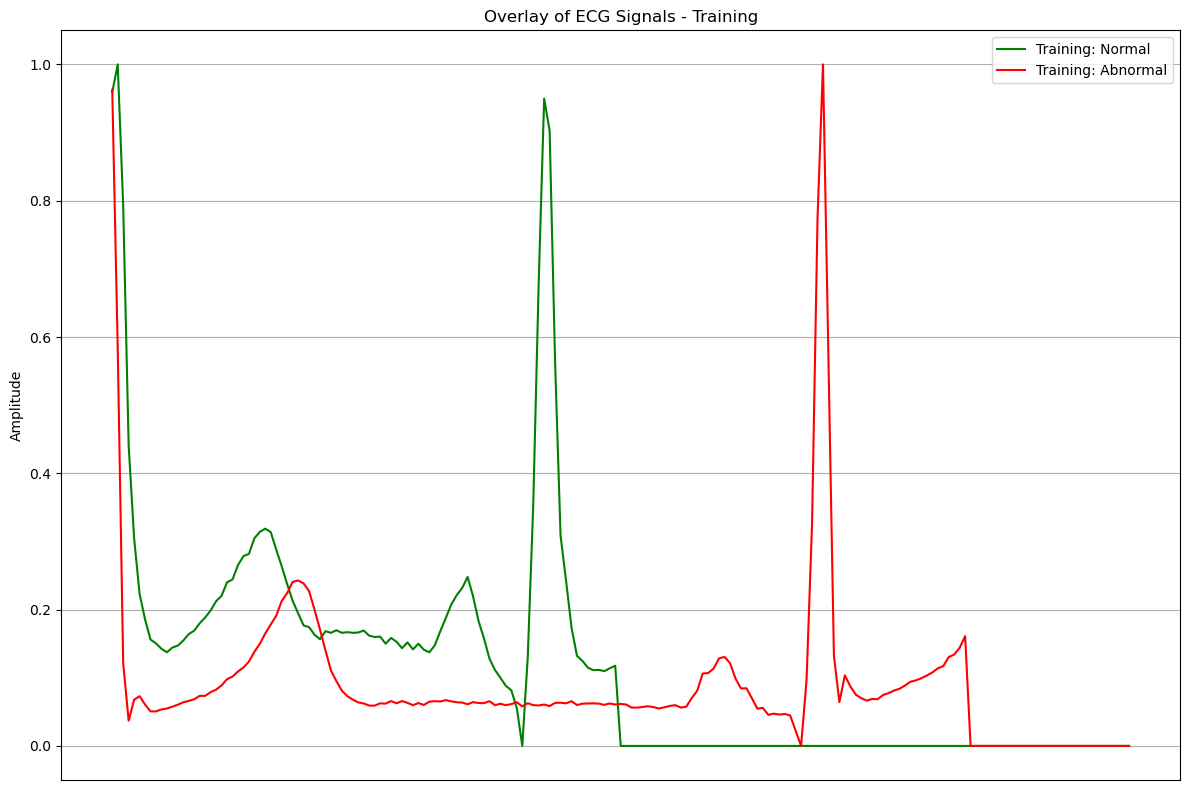

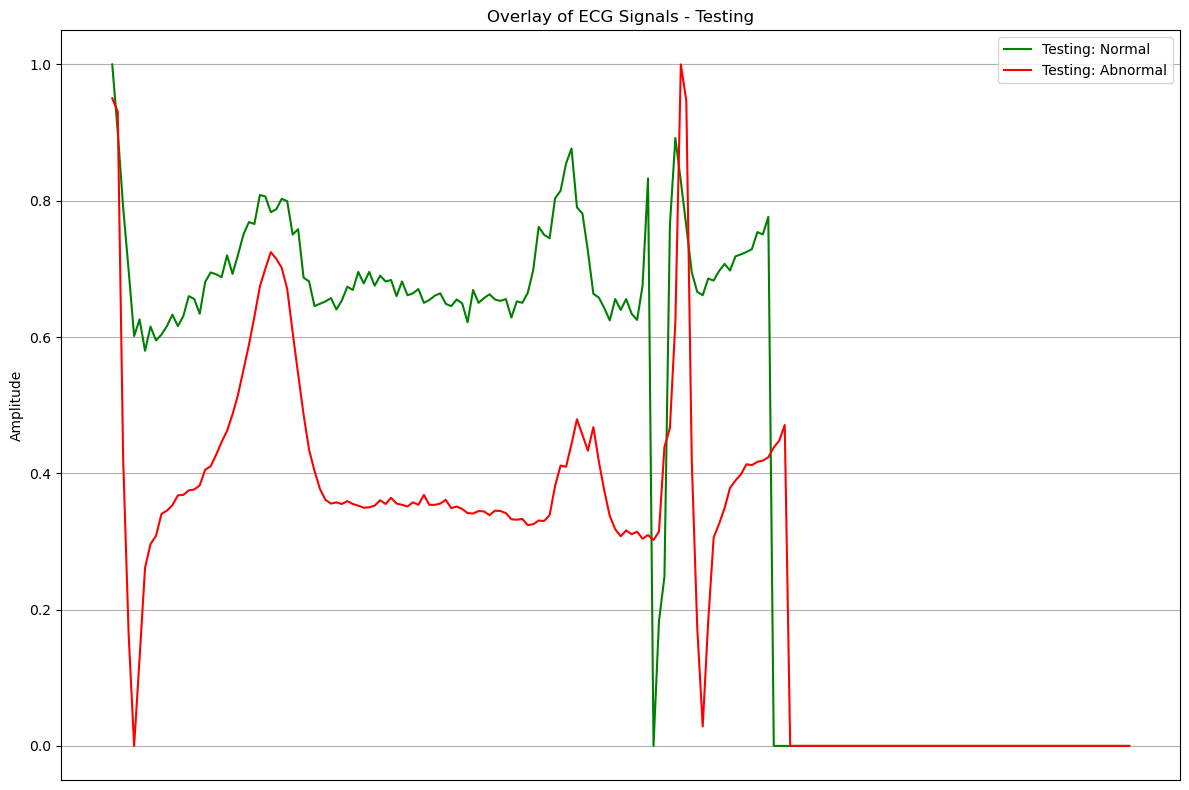

In [50]:
# Function to plot overlay of ECG signals from both datasets for a single class
def plot_overlay_ecg_signals(df, label, color, dataset_label): # Define a function to plot overlay of ECG signals for a single class from both datasets
    """
    Plot overlay of ECG signals for a single class from both datasets.

    Parameters:
    df (DataFrame): DataFrame containing ECG signals and target labels
    label (str or int): Class label to plot
    color (str): Color for the plot
    dataset_label (str): Label for the dataset (e.g., 'Training', 'Testing')
    """

    # Map the descriptive label to the corresponding class label
    if isinstance(label, str):
        class_label = [k for k, v in class_mapping.items() if v == label][0] # Get the class label for the specified class name
    else:
        class_label = label # Use the specified class label
    
    # Extract data rows for the specified class label
    class_data = df[df['target'] == class_label]

    # Check if there is any data for the specified class label
    if class_data.empty:
        print(f"No data found for class {class_mapping[class_label]}")
        return
    
    # Extract a sample data row (first row) for the specified class label
    sample_data = class_data.iloc[0]

    # Plot the sample ECG signal, excluding the 'target' column
    plt.plot(sample_data[:-1], label=f'{dataset_label}: {class_mapping[class_label]}', color=color)

    plt.title(f"Overlay of ECG Signals - {dataset_label}")
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.xticks([])  # Remove x-axis ticks and labels
    plt.legend()

# List of classes to plot
classes_to_plot = ['Normal', 'Abnormal']


# Colors for each class
colors = ['green','red']


# Plotting overlay for each class in both datasets
plt.figure(figsize=(12, 8))

# Plotting for training dataset
for label, color in zip(classes_to_plot, colors):
    plot_overlay_ecg_signals(ptbdb_train, label, color, 'Training')

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))

# Plotting for testing dataset
for label, color in zip(classes_to_plot, colors):
    plot_overlay_ecg_signals(ptbdb_test, label, color, 'Testing')

plt.tight_layout()
plt.show()

# Perform Histogram

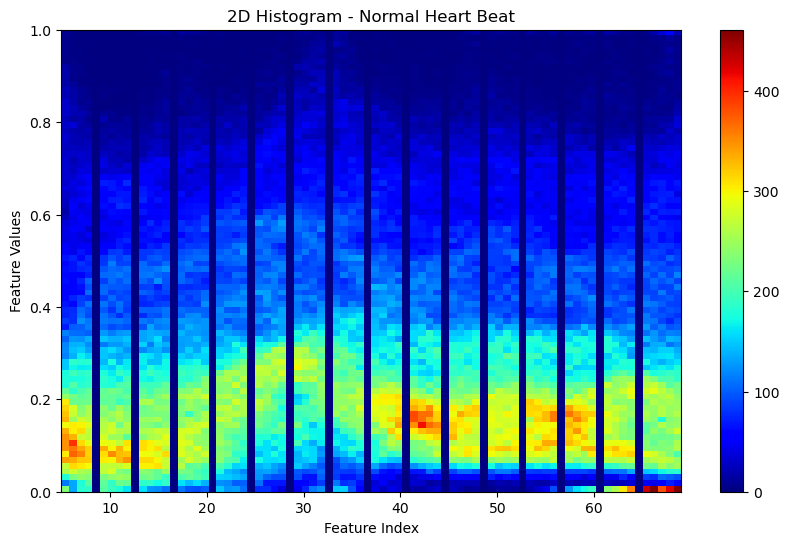

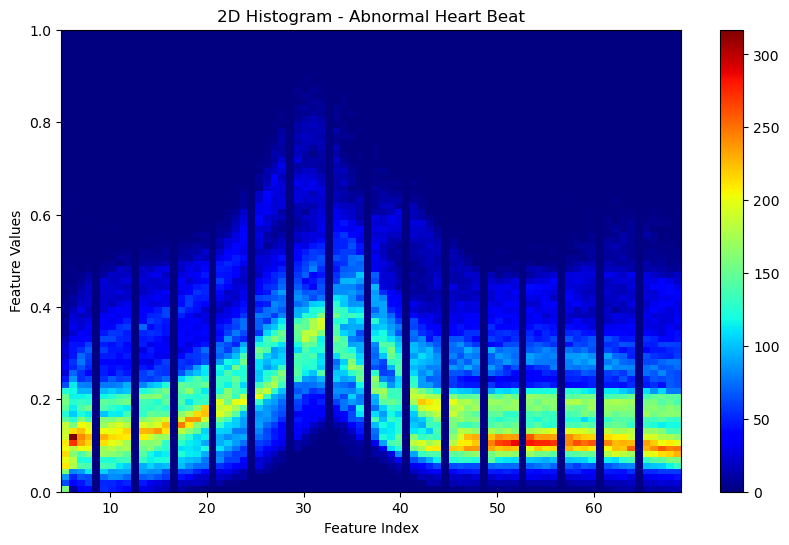

In [48]:
def plot_hist(class_name, min_val=5, size=70, title=''):
    # Map the descriptive label to the corresponding class label
    if isinstance(class_name, str):
        class_label = [k for k, v in class_mapping.items() if v == class_name][0]  # Convert class name to class label 
    else:
        class_label = class_name  # Use the specified class label directly if it's already a number
    
    # Filter the dataset based on the class_label
    img = ptbdb_train.loc[ptbdb_train['target'] == class_label].iloc[:, min_val:size]
    
    # Flatten the array
    img_flatten = img.values.flatten()
    
    # Generate corresponding x-values for the histogram
    x_values = np.tile(np.arange(min_val, size), img.shape[0])
    
    # Ensure that the lengths match for histogram plotting
    assert len(x_values) == len(img_flatten), "Mismatch in lengths of x-values and flattened image values."
    
    # Create the 2D histogram
    plt.figure(figsize=(10, 6))
    plt.hist2d(x_values, img_flatten, bins=(80, 80), cmap=plt.cm.jet)
    plt.colorbar()  # Add a color bar to indicate the intensity of values
    plt.title('2D Histogram - ' + title)
    plt.xlabel('Feature Index')
    plt.ylabel('Feature Values')
    plt.show()

# Plot for Normal Heart Beat
plot_hist('Normal', title='Normal Heart Beat')

# Plot for Abnormal Heart Beat
plot_hist('Abnormal', title='Abnormal Heart Beat')


# PCA Functions for training Dataset

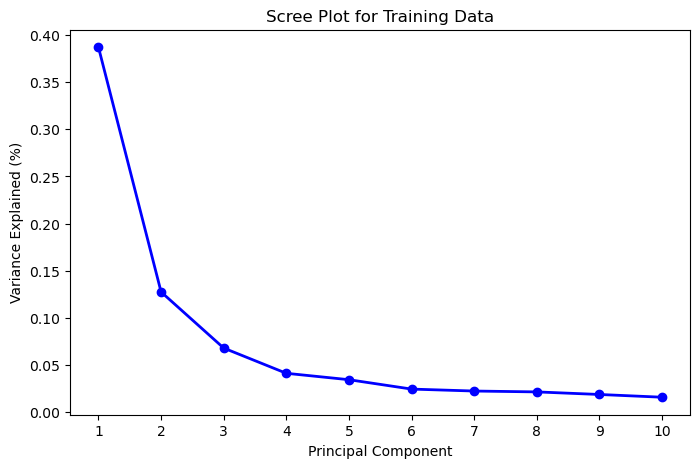

c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\plotly\express\_core.py:1979: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sf: grouped.get_group(s if len(s) > 1 else s[0])


c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\plotly\express\_core.py:1979: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



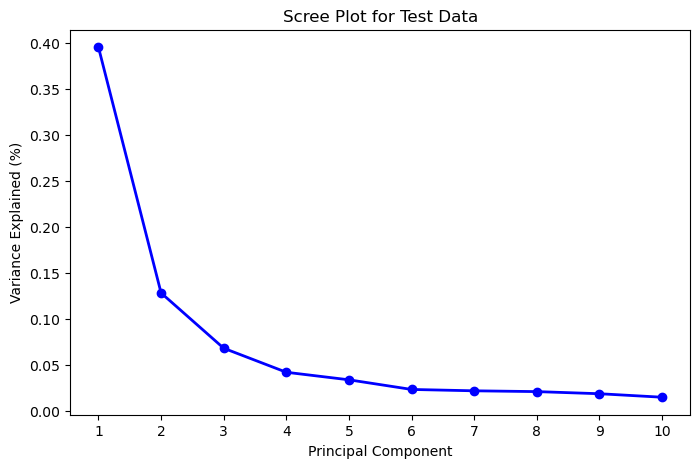

c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\plotly\express\_core.py:1979: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\plotly\express\_core.py:1979: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [51]:
# Define the function to apply PCA
def apply_pca_to_dataset(df, n_components=2):
    X = df.drop('target', axis=1)
    pca = PCA(n_components=n_components)
    components = pca.fit_transform(X)
    df_pca = pd.DataFrame(data=components, columns=[f'Principal Component {i+1}' for i in range(n_components)])
    df_pca['target'] = df['target']
    return df_pca, pca

# Define the function to plot PCA results (2D)
def plot_pca_results(df_pca, title='PCA of Dataset'):
    # Define custom colors and labels for each category
    color_mapping = {0: 'red', 1: 'green'}
    label_mapping = {0: 'Abnormal', 1: 'Normal'}
    
    # Map the target to the corresponding colors and labels
    df_pca['color'] = df_pca['target'].map(color_mapping)
    df_pca['label'] = df_pca['target'].map(label_mapping)

    # Create a scatter plot for the PCA results
    fig = px.scatter(df_pca, x='Principal Component 1', y='Principal Component 2', color='label',
                     color_discrete_map={'Normal': 'green', 'Abnormal': 'red'},
                     title=title, labels={'label': 'Class'}, opacity=0.5)
    fig.update_traces(marker=dict(size=5))
    fig.show()

# Define the function to create a Scree plot
def create_scree_plot(pca, title='Scree Plot'):
    explained_var_ratio = pca.explained_variance_ratio_
    components = np.arange(len(explained_var_ratio)) + 1

    plt.figure(figsize=(8, 5))
    plt.plot(components, explained_var_ratio, 'o-', linewidth=2, color='blue')
    plt.title(title)
    plt.xlabel('Principal Component')
    plt.ylabel('Variance Explained (%)')
    plt.xticks(components)
    plt.show()

# Apply PCA to the training dataset for 10 components to create the Scree plot
df_pca_train, pca_train = apply_pca_to_dataset(ptbdb_train, n_components=10)
create_scree_plot(pca_train, title='Scree Plot for Training Data')

# Apply PCA to the training dataset for 2 components and plot the 2D PCA results
df_pca_train, pca_train = apply_pca_to_dataset(ptbdb_train, n_components=2)
plot_pca_results(df_pca_train, title='PCA of Heartbeat Dataset (2D) - Training Data')

# Apply PCA to the training dataset for 3 components and plot the 3D PCA results
df_pca_train, pca_train = apply_pca_to_dataset(ptbdb_train, n_components=3)
df_pca_train['color'] = df_pca_train['target'].map({0: 'red', 1: 'green'})
df_pca_train['label'] = df_pca_train['target'].map({0: 'Abnormal', 1: 'Normal'})

fig = px.scatter_3d(df_pca_train, x='Principal Component 1', y='Principal Component 2', z='Principal Component 3',
                    color='label',
                    color_discrete_map={'Normal': 'green', 'Abnormal': 'red'},
                    title='3D PCA of Heartbeat Dataset - Training Data',
                    labels={'label': 'Class'}, opacity=0.5)
fig.update_traces(marker=dict(size=5))
fig.show()

# Apply PCA to the test dataset for 10 components to create the Scree plot
df_pca_test, pca_test = apply_pca_to_dataset(ptbdb_test, n_components=10)
create_scree_plot(pca_test, title='Scree Plot for Test Data')

# Apply PCA to the test dataset for 2 components and plot the 2D PCA results
df_pca_test, pca_test = apply_pca_to_dataset(ptbdb_test, n_components=2)
plot_pca_results(df_pca_test, title='PCA of Heartbeat Dataset (2D) - Test Data')

# Apply PCA to the test dataset for 3 components and plot the 3D PCA results
df_pca_test, pca_test = apply_pca_to_dataset(ptbdb_test, n_components=3)
df_pca_test['color'] = df_pca_test['target'].map({0: 'red', 1: 'green'})
df_pca_test['label'] = df_pca_test['target'].map({0: 'Abnormal', 1: 'Normal'})

fig = px.scatter_3d(df_pca_test, x='Principal Component 1', y='Principal Component 2', z='Principal Component 3',
                    color='label',
                    color_discrete_map={'Normal': 'green', 'Abnormal': 'red'},
                    title='3D PCA of Heartbeat Dataset - Test Data',
                    labels={'label': 'Class'}, opacity=0.5)
fig.update_traces(marker=dict(size=5))
fig.show()



# Look at the loadings to determine which variables are most significant in each principal component in training data set

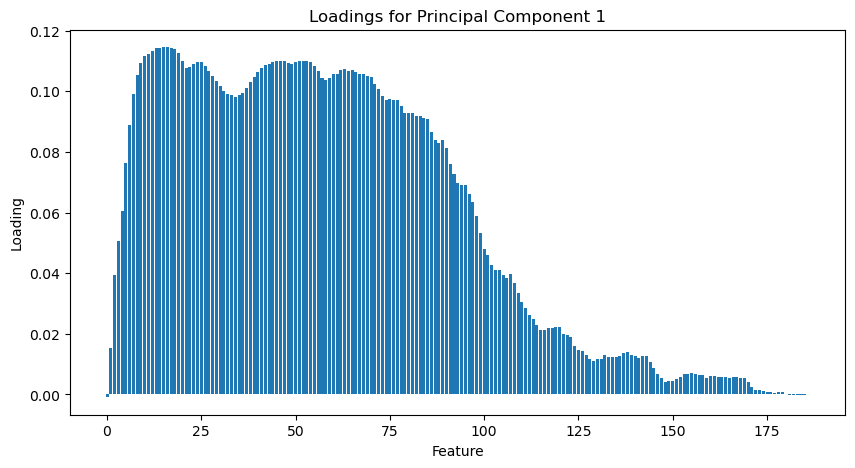

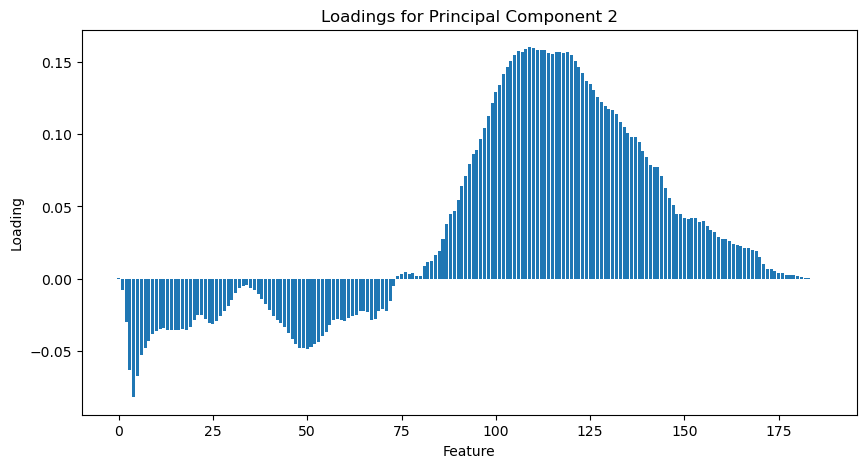

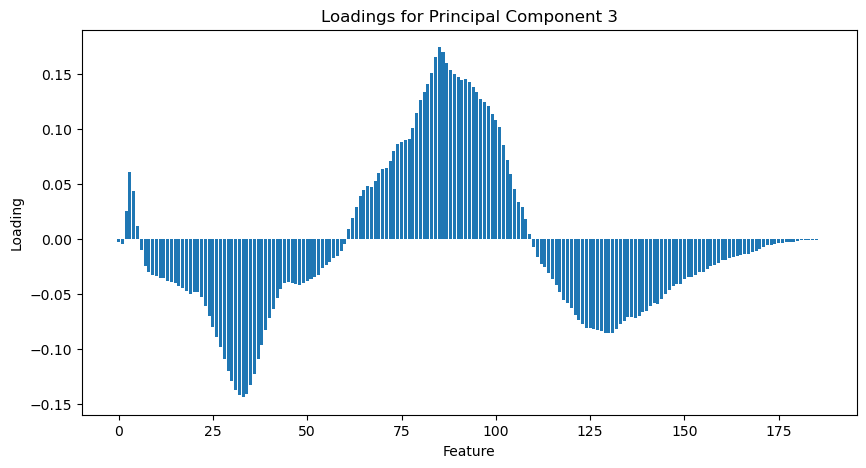

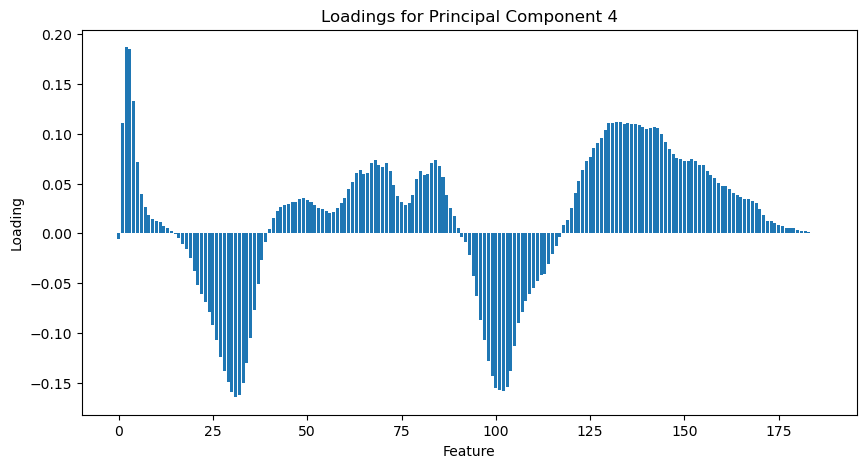

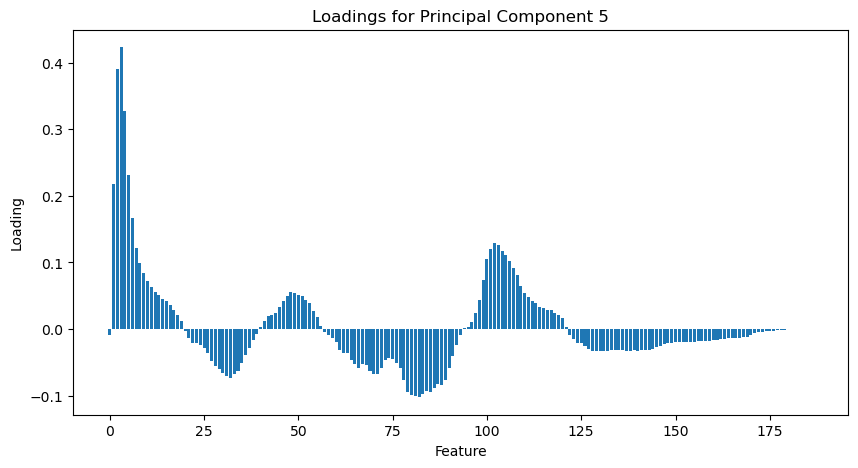

In [52]:
# train
df_pca, pca = apply_pca_to_dataset(ptbdb_train, n_components=5)

loadings = pca.components_ # Get the loadings for the principal components (eigenvectors)

for i, component in enumerate(loadings):

    plt.figure(figsize=(10, 5))


    plt.bar(x=range(len(component)), height=component)


    plt.xlabel('Feature')
    plt.ylabel('Loading')
    plt.title(f'Loadings for Principal Component {i+1}')

    plt.show()

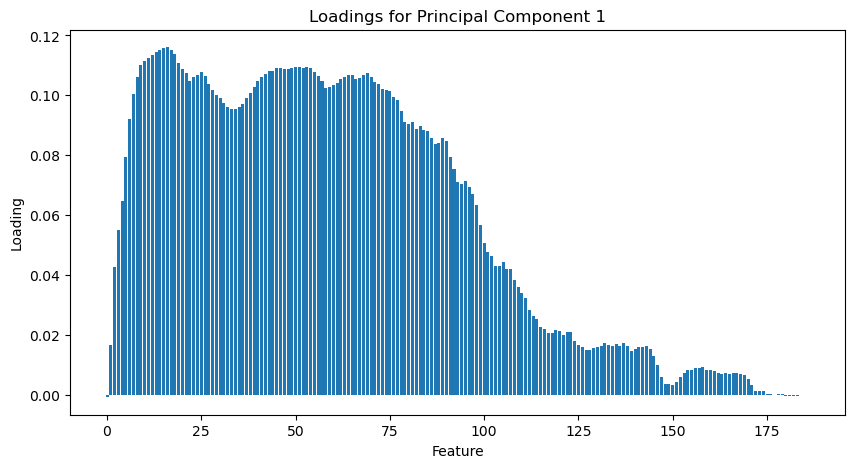

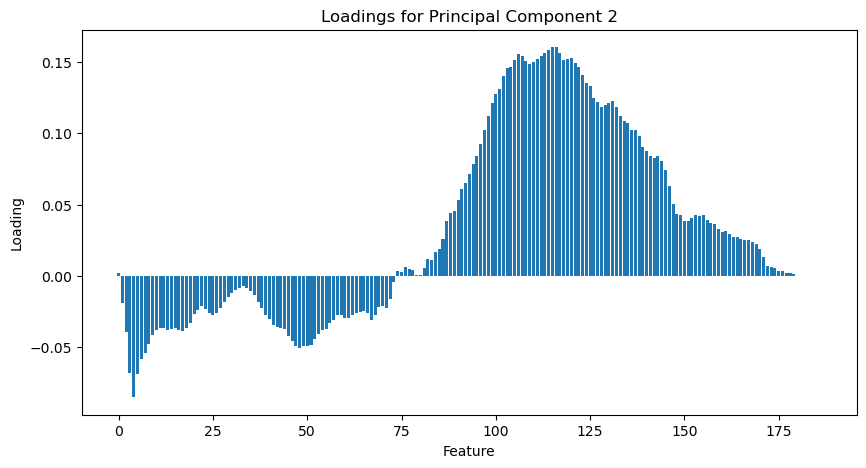

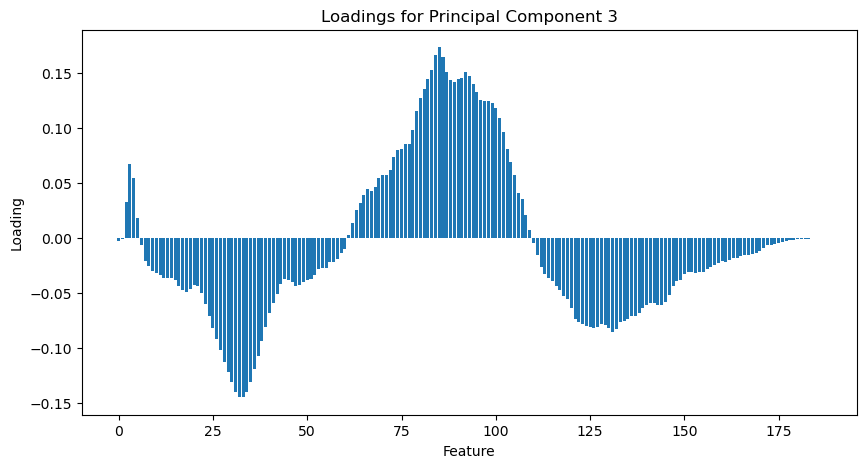

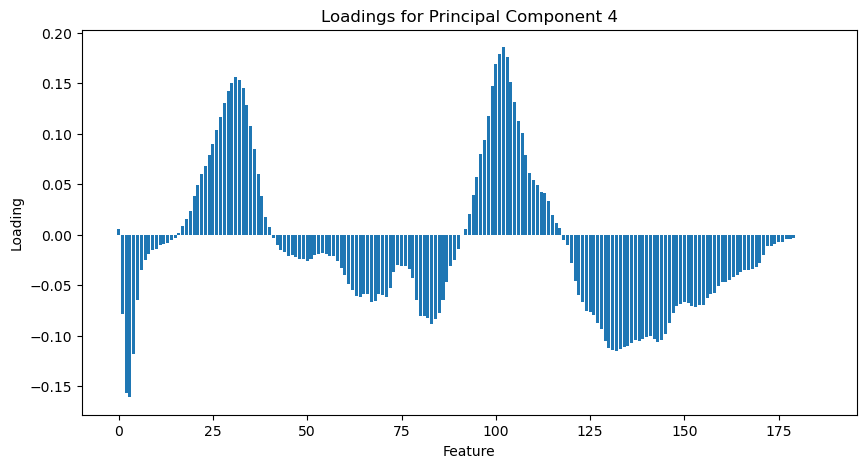

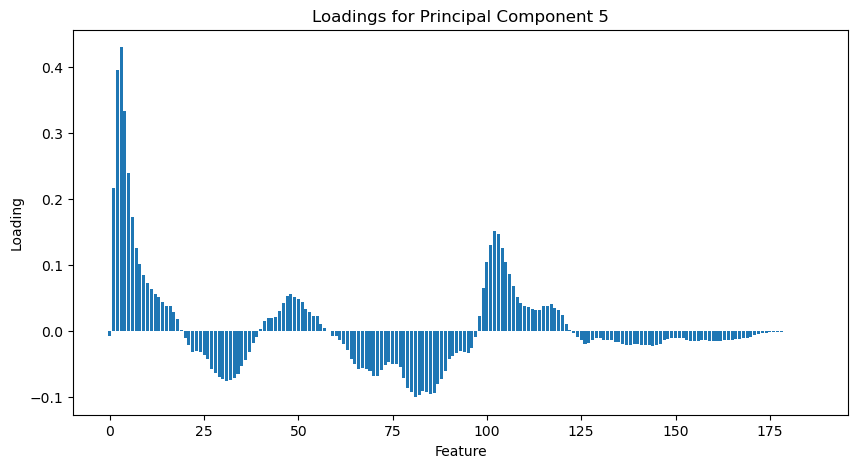

In [53]:
# test
df_pca, pca = apply_pca_to_dataset(ptbdb_test, n_components=5)


loadings = pca.components_


for i, component in enumerate(loadings):

    plt.figure(figsize=(10, 5))


    plt.bar(x=range(len(component)), height=component)


    plt.xlabel('Feature')
    plt.ylabel('Loading')
    plt.title(f'Loadings for Principal Component {i+1}')

    plt.show()

# Identify significant features

In [54]:
from scipy.stats import f_oneway, kruskal
# Separate features and labels
features = ptbdb_train.iloc[:, :-1]
labels = ptbdb_train['target']

p_values = []

for i in range(features.shape[1]):

    class_groups = [features[labels == label].iloc[:, i] for label in class_mapping.values()]

    # If not normally distributed, use Kruskal-Wallis H-test
    h_stat, p_val = kruskal(*class_groups)
    p_values.append(p_val)


adjusted_p_values = [p * len(p_values) for p in p_values]

# Select features with p-value below the significance level
significant_features = [i for i, p_val in enumerate(adjusted_p_values) if p_val < 0.05]

print(f'Number of significant features: {len(significant_features)}')
# print(f'Significant features: {significant_features}')

print('The absence of significant features suggests that the classes may not be well-separated in the original feature space,\n which could make it challenging for PCA and t-SNE to clearly distinguish between them.')

Number of significant features: 0
The absence of significant features suggests that the classes may not be well-separated in the original feature space,
 which could make it challenging for PCA and t-SNE to clearly distinguish between them.


# Perform t_SNE in training set

c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning:

Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.

  File "c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


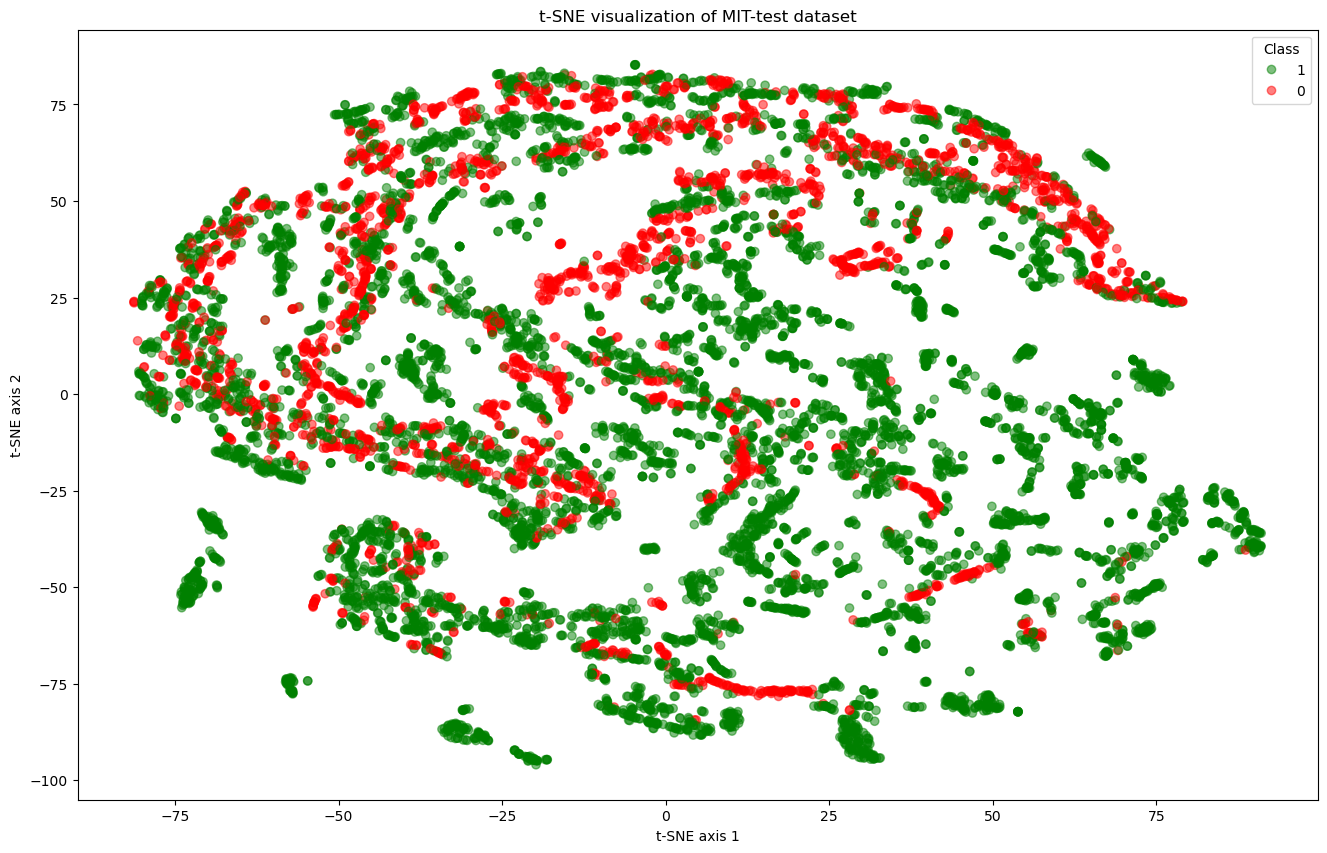

In [55]:
# Separate features and labels
features = ptbdb_train.iloc[:, :-1]
labels = ptbdb_train.iloc[:, -1]

# Reduce dimensionality with PCA
pca = PCA(n_components=50)
features_pca = pca.fit_transform(features)

# Initialize t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)

# Perform t-SNE
tsne_results = tsne.fit_transform(features_pca)

# Plot the results
plt.figure(figsize=(16,10))
unique_labels = labels.unique()
label_to_number = {label: number for number, label in enumerate(unique_labels)}
colors = labels.map(label_to_number)

# Define your discrete color scale
color_discrete_scale = ['green', 'red']

# Create a ListedColormap object with the defined colors
cmap = ListedColormap(color_discrete_scale[:len(unique_labels)])

scatter = plt.scatter(tsne_results[:,0], tsne_results[:,1], c=colors, cmap=cmap, alpha=0.5)
plt.title('t-SNE visualization of MIT-test dataset')
plt.xlabel('t-SNE axis 1')
plt.ylabel('t-SNE axis 2')

# Create a legend with the correct labels
handles, _ = scatter.legend_elements()
plt.legend(handles, unique_labels, title='Class')

plt.show()


# Perform t_SNE in test set

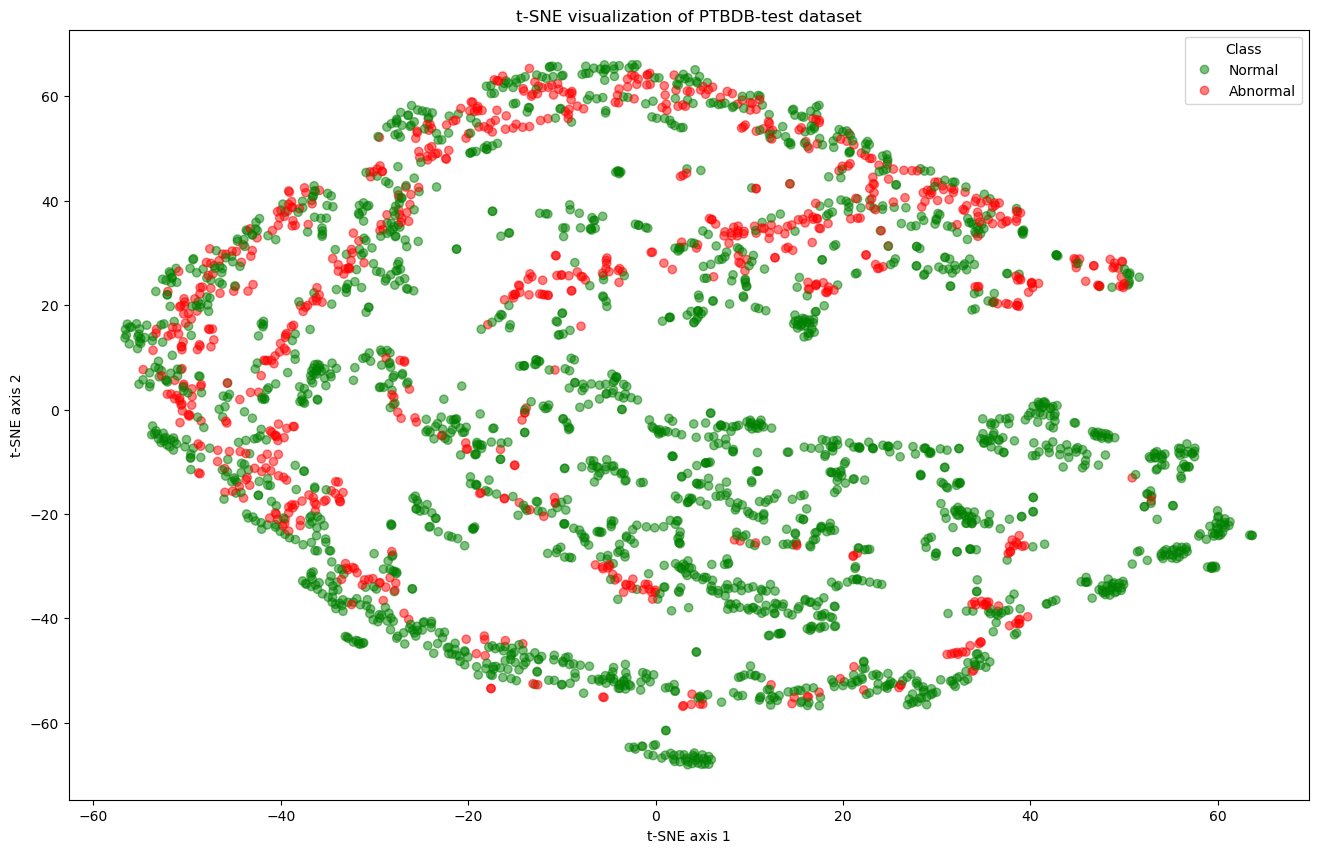

In [56]:
# Separate features and labels
features = ptbdb_test.iloc[:, :-1]
labels = ptbdb_test.iloc[:, -1]

# Reduce dimensionality with PCA
pca = PCA(n_components=50)
features_pca = pca.fit_transform(features)

# Initialize t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)

# Perform t-SNE
tsne_results = tsne.fit_transform(features_pca)

# Plot the results
plt.figure(figsize=(16,10))
unique_labels = labels.unique()
label_to_number = {label: number for number, label in enumerate(unique_labels)}
colors = labels.map(label_to_number)

# Define your discrete color scale
color_discrete_scale = ['green', 'red']

# Create a ListedColormap object with the defined colors
cmap = ListedColormap(color_discrete_scale[:len(unique_labels)])

scatter = plt.scatter(tsne_results[:,0], tsne_results[:,1], c=colors, cmap=cmap, alpha=0.5)
plt.title('t-SNE visualization of PTBDB-test dataset')
plt.xlabel('t-SNE axis 1')
plt.ylabel('t-SNE axis 2')
plt.legend(handles=scatter.legend_elements()[0], labels=['Normal', 'Abnormal'], title='Class')
plt.show()


# Perform UMAP in training set (UMAP does not work for me, HELP!)

In [70]:
# from umap import UMAP

# # Drop target column from the training data
# features = ptbdb_train.drop(columns=['target'])

# # Apply UMAP
# umap_model = UMAP(n_components=2, random_state=42)  # Instantiate UMAP model
# df_umap = umap_model.fit_transform(features)  # Fit and transform the data

# # Define color mapping for target labels
# label_to_color = {0: 'red', 1: 'green'}  # Assuming 0 is Abnormal, 1 is Normal
# colors = ptbdb_train['target'].map(label_to_color)

# # Create the plot
# plt.figure(figsize=(16, 10))

# # Scatter plot of UMAP results
# scatter = plt.scatter(df_umap[:, 0], df_umap[:, 1], c=colors, alpha=0.5)

# # Create a custom legend
# handles = [
#     plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Abnormal'),
#     plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Normal')
# ]

# plt.title('UMAP Visualization of PTBDB Train Dataset')
# plt.xlabel('UMAP Axis 1')
# plt.ylabel('UMAP Axis 2')
# plt.legend(handles=handles, title='Class')
# plt.show()

# Perform UMAP in test set

In [71]:
# from umap import UMAP
# # Drop target column from test data
# features = ptbdb_test.drop(columns=['target'])

# # Apply UMAP
# umap_model = umap.UMAP(n_components=2, random_state=42)
# df_umap = umap_model.fit_transform(features)

# # Get unique labels and create a mapping
# unique_labels = ptbdb_test['target'].unique()
# label_to_color = {0: 'red', 1: 'green'}
# colors = ptbdb_test['target'].map(label_to_color)

# # Create the plot
# plt.figure(figsize=(16, 10))

# # Scatter plot of UMAP results
# scatter = plt.scatter(df_umap[:, 0], df_umap[:, 1], c=colors, cmap='viridis', alpha=0.5)

# # Create a custom legend
# handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Abnormal'),
#            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Normal')]

# plt.title('UMAP Visualization of PTBDB Test Dataset')
# plt.xlabel('UMAP Axis 1')
# plt.ylabel('UMAP Axis 2')
# plt.legend(handles=handles, title='Class')
# plt.show()

# Prepare Data for modeling and Preprocessing

In [72]:
num_cases_target_1 = ptbdb_train['target'].value_counts()[1] # [1] =  Normal
print("1 = Normal:", num_cases_target_1)

num_cases_target_0 = ptbdb_train['target'].value_counts()[0] # [0] = Abnormal
print("0 = Abnormal:",num_cases_target_0) # Attention: The Coding for target is exactly the opposite of the MIT-BIH dataset!!!!!!

1 = Normal: 8386
0 = Abnormal: 3252


# load and split cleaned data

Class distribution in training
 target
1    0.720571
0    0.279429
Name: proportion, dtype: float64

Class distribution in test
 target
1    0.727148
0    0.272852
Name: proportion, dtype: float64




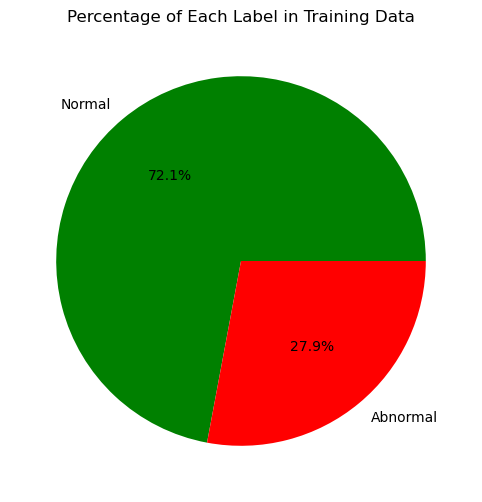

In [73]:
# File paths
train_file_path = 'ptbdb_train_clean.csv'
test_file_path = 'ptbdb_test_clean.csv'

# If the cleaned data files do not exist, save them
if not os.path.isfile(train_file_path) or not os.path.isfile(test_file_path):
    # Read the data
    # Encode the labels
    ptbdb_train['target'] = ptbdb_train['target'].replace({'Normal': 1, 'Abnormal': 0})
    ptbdb_test['target'] = ptbdb_test['target'].replace({'Normal': 1, 'Abnormal': 0})

    # Save cleaned data
    ptbdb_train.to_csv(train_file_path, index=False)
    ptbdb_test.to_csv(test_file_path, index=False)
else:
    print("Cleaned data files already exist.")

# Read cleaned data
try:
    ptbdb_train = pd.read_csv(train_file_path, header=0)
    ptbdb_test = pd.read_csv(test_file_path, header=0)
except FileNotFoundError:
    print(f"Error: The file {train_file_path} or {test_file_path} does not exist.")
    # Optionally, add code to handle this case, e.g., exit or retry

# Show the distribution of the two classes
print('Class distribution in training\n', ptbdb_train['target'].value_counts(normalize=True))
print('\nClass distribution in test\n', ptbdb_test['target'].value_counts(normalize=True))
print('\n')

# Plot a pie chart for training data class distribution
label_counts = ptbdb_train['target'].value_counts(normalize=True)
colors = ['green', 'red']
labels = ['Normal', 'Abnormal']

plt.figure(figsize=(10, 6))
plt.pie(label_counts, labels=labels, colors=colors, autopct='%1.1f%%')
plt.title('Percentage of Each Label in Training Data')
plt.show()


In [74]:
# Split the data into features (X) and target (y)
X_train = ptbdb_train.drop(columns=['target'])
y_train = ptbdb_train['target']

X_test = ptbdb_test.drop(columns=['target'])
y_test = ptbdb_test['target']

In [75]:
# to find the distribution of our variables, follow the normal distribution or not
from scipy.stats import kstest
normal_vars = []
non_normal_vars = []

for i in range(187):  # 0 to 186
    stat, p = kstest(X_train.iloc[:, i], 'norm')
    if p > 0.05:
        normal_vars.append(f'Variable {i}')
    else:
        non_normal_vars.append(f'Variable {i}')

print("Variables following normal distribution:")
print(normal_vars)
if len(non_normal_vars) == 187:
    print("Since our variables do not follow a normal distribution, it is advisable to use scaling methods such as MinMaxScaler or RobustScaler, which are better suited for data that does not conform to a normal distribution.")

Variables following normal distribution:
[]
Since our variables do not follow a normal distribution, it is advisable to use scaling methods such as MinMaxScaler or RobustScaler, which are better suited for data that does not conform to a normal distribution.


# Finding the best Rescaling

In [92]:
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier


# Define recommended scalers
scalers = {
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler(),
    "RobustScaler": RobustScaler()
}

# Define models to evaluate
models = {
    "LogisticRegression": LogisticRegression(class_weight='balanced', max_iter=1000),
    "RandomForest": RandomForestClassifier(class_weight='balanced'),
    "SVM": SVC(class_weight='balanced'),
    "KNN": KNeighborsClassifier(),
    "GradientBoosting": GradientBoostingClassifier(),
    "LightGBM": LGBMClassifier(class_weight='balanced'),
    "XGBClassifier": XGBClassifier(class_weight='balanced')
}

def evaluate_scalers(X, y, scalers, models):
    results = {}
    for scaler_name, scaler in scalers.items():
        print(f"Scaler: {scaler_name}", end="\n\n")
        X_scaled = scaler.fit_transform(X)

        skf = StratifiedKFold(n_splits=5)

        for model_name, model in models.items():
            f_score = []
            print(f"Model: {model_name}", end="\n\n")

            for train_index, test_index in skf.split(X_scaled, y):
                X_train_, y_train_ = X_scaled[train_index], y[train_index]
                X_test_, y_test_ = X_scaled[test_index], y[test_index]

                model.fit(X_train_, y_train_)

                y_pred_ = model.predict(X_test_)

                f_score.append(f1_score(y_test_, y_pred_))

            mean_f1_score = np.mean(f_score)
            print("The scores: ", end="\n\n")
            print([round(f, 2) for f in f_score], end="\n\n")
            print('F1-Score mean=%.5f' % (mean_f1_score), end="\n\n")

            if scaler_name not in results:
                results[scaler_name] = {}
            results[scaler_name][model_name] = mean_f1_score
    return results

# Apply evaluation
results = evaluate_scalers(X_train, y_train, scalers, models)
# Summarize the results
for scaler_name, model_scores in results.items():
    print(f"Scaler: {scaler_name}")
    for model_name, score in model_scores.items():
        print(f"  Model: {model_name}, F1-Score mean: {score:.5f}")
    print("\n")


Scaler: StandardScaler

Model: LogisticRegression

The scores: 

[0.85, 0.83, 0.84, 0.84, 0.82]

F1-Score mean=0.83649

Model: RandomForest

The scores: 

[0.98, 0.97, 0.98, 0.98, 0.97]

F1-Score mean=0.97627

Model: SVM

The scores: 

[0.91, 0.91, 0.91, 0.91, 0.9]

F1-Score mean=0.91020

Model: KNN

The scores: 

[0.94, 0.95, 0.94, 0.95, 0.94]

F1-Score mean=0.94285

Model: GradientBoosting

The scores: 

[0.96, 0.95, 0.95, 0.96, 0.95]

F1-Score mean=0.95140

Model: LightGBM

[LightGBM] [Info] Number of positive: 6708, number of negative: 2602
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41856
[LightGBM] [Info] Number of data points in the train set: 9310, number of used features: 183
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of

c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\xgboost\core.py:158: UserWarning:

[15:09:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.


c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\xgboost\core.py:158: UserWarning:

[15:09:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.


c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\xgboost\core.py:158: UserWarning:

[15:09:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.


c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\xg

The scores: 

[0.98, 0.99, 0.98, 0.98, 0.98]

F1-Score mean=0.98303

Scaler: MinMaxScaler

Model: LogisticRegression

The scores: 

[0.85, 0.82, 0.83, 0.83, 0.82]

F1-Score mean=0.83089

Model: RandomForest

The scores: 

[0.98, 0.97, 0.97, 0.98, 0.97]

F1-Score mean=0.97525

Model: SVM

The scores: 

[0.9, 0.89, 0.9, 0.9, 0.89]

F1-Score mean=0.89723

Model: KNN

The scores: 

[0.94, 0.95, 0.94, 0.95, 0.95]

F1-Score mean=0.94639

Model: GradientBoosting

The scores: 

[0.96, 0.95, 0.95, 0.96, 0.95]

F1-Score mean=0.95140

Model: LightGBM

[LightGBM] [Info] Number of positive: 6708, number of negative: 2602
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41822
[LightGBM] [Info] Number of data points in the train set: 9310, number of used features: 183
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Inf

c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\xgboost\core.py:158: UserWarning:

[15:13:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.


c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\xgboost\core.py:158: UserWarning:

[15:13:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.


c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\xgboost\core.py:158: UserWarning:

[15:13:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.


c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\xg

The scores: 

[0.98, 0.99, 0.98, 0.98, 0.98]

F1-Score mean=0.98303

Scaler: RobustScaler

Model: LogisticRegression

The scores: 

[0.85, 0.83, 0.84, 0.84, 0.83]

F1-Score mean=0.83526

Model: RandomForest

The scores: 

[0.98, 0.97, 0.98, 0.98, 0.98]

F1-Score mean=0.97661

Model: SVM

The scores: 

[0.87, 0.86, 0.87, 0.86, 0.86]

F1-Score mean=0.86542

Model: KNN

The scores: 

[0.93, 0.93, 0.93, 0.93, 0.93]

F1-Score mean=0.92946

Model: GradientBoosting

The scores: 

[0.96, 0.95, 0.95, 0.96, 0.95]

F1-Score mean=0.95140

Model: LightGBM

[LightGBM] [Info] Number of positive: 6708, number of negative: 2602
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009963 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41822
[LightGBM] [Info] Number of data points in the train set: 9310, number of used features: 183
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [

c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\xgboost\core.py:158: UserWarning:

[15:16:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.


c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\xgboost\core.py:158: UserWarning:

[15:16:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.


c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\xgboost\core.py:158: UserWarning:

[15:16:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.


c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\xg

The scores: 

[0.98, 0.99, 0.98, 0.98, 0.98]

F1-Score mean=0.98303

Scaler: StandardScaler
  Model: LogisticRegression, F1-Score mean: 0.83649
  Model: RandomForest, F1-Score mean: 0.97627
  Model: SVM, F1-Score mean: 0.91020
  Model: KNN, F1-Score mean: 0.94285
  Model: GradientBoosting, F1-Score mean: 0.95140
  Model: LightGBM, F1-Score mean: 0.98103
  Model: XGBClassifier, F1-Score mean: 0.98303


Scaler: MinMaxScaler
  Model: LogisticRegression, F1-Score mean: 0.83089
  Model: RandomForest, F1-Score mean: 0.97525
  Model: SVM, F1-Score mean: 0.89723
  Model: KNN, F1-Score mean: 0.94639
  Model: GradientBoosting, F1-Score mean: 0.95140
  Model: LightGBM, F1-Score mean: 0.97948
  Model: XGBClassifier, F1-Score mean: 0.98303


Scaler: RobustScaler
  Model: LogisticRegression, F1-Score mean: 0.83526
  Model: RandomForest, F1-Score mean: 0.97661
  Model: SVM, F1-Score mean: 0.86542
  Model: KNN, F1-Score mean: 0.92946
  Model: GradientBoosting, F1-Score mean: 0.95140
  Model: LightGBM,

# Apply the best rescaling method

In [94]:
# Determine the best scaler based on the highest average F1-score
best_scaler_name = max(results, key=lambda k: np.mean(list(results[k].values())))
best_scaler = scalers[best_scaler_name]
print(f"Best Scaler: {best_scaler_name}")

print("In general, the models perform best with StandardScaler. However, the differences in performance among the scaling methods are very small. They rather differ between the applied models. XGboost was the best performing (ensamble) model, followed by Light GBM and Random Forest. Logistic Regression and SVM performed the worst.")

Best Scaler: StandardScaler
In general, the models perform best with StandardScaler. However, the differences in performance among the scaling methods are very small. They rather differ between the applied models. XGboost was the best performing (ensamble) model, followed by Light GBM and Random Forest. Logistic Regression and SVM performed the worst.


In [95]:
# Fit the best scaler on the training data and transform it
scaler = StandardScaler()
# Fit the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)
# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)


# Convert the numpy arrays to pandas DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# find the best resampling method

In [99]:
# When dealing with imbalanced datasets, especially those that reflect real-world scenarios,
# it’s important to use both resampling methods and appropriate loss functions to improve model performance.

def crossvalidation(X, y, models):
    resampling_methods = {
        "SMOTE": SMOTE(),
        "Oversampling": RandomOverSampler(sampling_strategy='not majority'),
        "Undersampling": RandomUnderSampler(sampling_strategy='majority'),
        "BalancedRandomForest": BalancedRandomForestClassifier(random_state=42)
    }

    skf = StratifiedKFold(n_splits=5)
    results = {}

    for name, resample in resampling_methods.items():
        print(name, end="\n\n")
        results[name] = {}

        for model_name, model in models.items():
            f_score = []
            print(f"Model: {model_name}", end="\n\n")

            for train_index, test_index in skf.split(X, y):
                X_train_, y_train_ = X.loc[train_index], y.loc[train_index]
                X_test_, y_test_ = X.loc[test_index], y.loc[test_index]

                if name == "BalancedRandomForest":
                    model.fit(X_train_, y_train_)
                else:
                    X_train_resampled, y_train_resampled = resample.fit_resample(X_train_, y_train_)
                    model.fit(X_train_resampled, y_train_resampled)

                y_pred_ = model.predict(X_test_)

                f_score.append(f1_score(y_test_, y_pred_))

            results[name][model_name] = np.mean(f_score)
            print("The scores: ", end="\n\n")
            print([round(f, 2) for f in f_score], end="\n\n")
            print('F1-Score mean=%.5f' % (np.mean(f_score)), end="\n\n")

    return results, resampling_methods

models = {
    "LogisticRegression": LogisticRegression(class_weight='balanced', max_iter=1000),
    "RandomForest": RandomForestClassifier(class_weight='balanced'),
    "SVM": SVC(class_weight='balanced'),
    "KNN": KNeighborsClassifier(),
    "GradientBoosting": GradientBoostingClassifier(),
    "LightGBM": LGBMClassifier(class_weight='balanced'),
    "XGBClassifier": XGBClassifier()
}

# Apply cross-validation with resampling
results_resample, resampling_methods = crossvalidation(X_train_scaled, y_train, models)


SMOTE

Model: LogisticRegression

The scores: 

[0.84, 0.83, 0.84, 0.84, 0.82]

F1-Score mean=0.83549

Model: RandomForest

The scores: 

[0.98, 0.97, 0.98, 0.98, 0.97]

F1-Score mean=0.97571

Model: SVM

The scores: 

[0.93, 0.93, 0.93, 0.93, 0.93]

F1-Score mean=0.92895

Model: KNN

The scores: 

[0.92, 0.92, 0.92, 0.93, 0.92]

F1-Score mean=0.92442

Model: GradientBoosting

The scores: 

[0.94, 0.93, 0.94, 0.93, 0.93]

F1-Score mean=0.93201

Model: LightGBM

[LightGBM] [Info] Number of positive: 6708, number of negative: 6708
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43158
[LightGBM] [Info] Number of data points in the train set: 13416, number of used features: 186
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 6709, number of negative: 6709
[LightGBM] [Info] Auto-cho

c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\xgboost\core.py:158: UserWarning:

[15:32:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.


c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\xgboost\core.py:158: UserWarning:

[15:32:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.


c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\xgboost\core.py:158: UserWarning:

[15:32:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.


c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\xg

The scores: 

[0.98, 0.98, 0.98, 0.98, 0.98]

F1-Score mean=0.98140

Oversampling

Model: LogisticRegression

The scores: 

[0.85, 0.83, 0.84, 0.84, 0.83]

F1-Score mean=0.83700

Model: RandomForest

The scores: 

[0.98, 0.98, 0.98, 0.98, 0.97]

F1-Score mean=0.97766

Model: SVM

The scores: 

[0.93, 0.93, 0.93, 0.92, 0.92]

F1-Score mean=0.92521

Model: KNN

The scores: 

[0.93, 0.92, 0.93, 0.93, 0.93]

F1-Score mean=0.92545

Model: GradientBoosting

The scores: 

[0.94, 0.93, 0.93, 0.93, 0.93]

F1-Score mean=0.93282

Model: LightGBM

[LightGBM] [Info] Number of positive: 6708, number of negative: 6708
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42754
[LightGBM] [Info] Number of data points in the train set: 13416, number of used features: 184
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] N

c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\xgboost\core.py:158: UserWarning:

[15:37:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.


c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\xgboost\core.py:158: UserWarning:

[15:37:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.


c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\xgboost\core.py:158: UserWarning:

[15:37:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.


c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\xg

The scores: 

[0.98, 0.99, 0.98, 0.99, 0.98]

F1-Score mean=0.98357

Undersampling

Model: LogisticRegression

The scores: 

[0.84, 0.83, 0.84, 0.83, 0.82]

F1-Score mean=0.83253

Model: RandomForest

The scores: 

[0.97, 0.96, 0.96, 0.96, 0.95]

F1-Score mean=0.95871

Model: SVM

The scores: 

[0.89, 0.89, 0.89, 0.89, 0.88]

F1-Score mean=0.88931

Model: KNN

The scores: 

[0.89, 0.88, 0.89, 0.88, 0.88]

F1-Score mean=0.88360

Model: GradientBoosting

The scores: 

[0.93, 0.92, 0.93, 0.93, 0.92]

F1-Score mean=0.92810

Model: LightGBM

[LightGBM] [Info] Number of positive: 2602, number of negative: 2602
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40672
[LightGBM] [Info] Number of data points in the train set: 5204, number of used features: 182
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] N

c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\xgboost\core.py:158: UserWarning:

[15:39:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.


c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\xgboost\core.py:158: UserWarning:

[15:39:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.


c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\xgboost\core.py:158: UserWarning:

[15:39:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.


c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\xg

The scores: 

[0.97, 0.97, 0.97, 0.97, 0.97]

F1-Score mean=0.96828

BalancedRandomForest

Model: LogisticRegression

The scores: 

[0.85, 0.83, 0.84, 0.84, 0.82]

F1-Score mean=0.83649

Model: RandomForest

The scores: 

[0.98, 0.97, 0.97, 0.98, 0.97]

F1-Score mean=0.97617

Model: SVM

The scores: 

[0.91, 0.91, 0.91, 0.91, 0.9]

F1-Score mean=0.91020

Model: KNN

The scores: 

[0.94, 0.95, 0.94, 0.95, 0.94]

F1-Score mean=0.94285

Model: GradientBoosting

The scores: 

[0.96, 0.95, 0.95, 0.96, 0.95]

F1-Score mean=0.95140

Model: LightGBM

[LightGBM] [Info] Number of positive: 6708, number of negative: 2602
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41856
[LightGBM] [Info] Number of data points in the train set: 9310, number of used features: 183
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [I

c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\xgboost\core.py:158: UserWarning:

[15:42:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.


c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\xgboost\core.py:158: UserWarning:

[15:42:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.


c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\xgboost\core.py:158: UserWarning:

[15:42:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.


c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\xg

The scores: 

[0.98, 0.99, 0.98, 0.98, 0.98]

F1-Score mean=0.98303



# Find and Apply the best Resampling method

In [100]:
# Compare results
print("Results with Resampling:")
print(results_resample)

# Determine the best resampling method
best_method = max(results_resample, key=lambda k: np.mean(list(results_resample[k].values())))
print(f"\nBest Resampling Method: {best_method}")

# Apply the best resampling method to the entire dataset
best_resampler = resampling_methods[best_method]




Results with Resampling:
{'SMOTE': {'LogisticRegression': 0.8354870863507337, 'RandomForest': 0.975707436916806, 'SVM': 0.9289458981667005, 'KNN': 0.9244222578049989, 'GradientBoosting': 0.9320133686576344, 'LightGBM': 0.9780412064327917, 'XGBClassifier': 0.9814000844939604}, 'Oversampling': {'LogisticRegression': 0.8370013868944296, 'RandomForest': 0.9776634883208057, 'SVM': 0.9252134381244401, 'KNN': 0.9254521902939075, 'GradientBoosting': 0.9328208655746169, 'LightGBM': 0.9810077934382024, 'XGBClassifier': 0.9835729718631093}, 'Undersampling': {'LogisticRegression': 0.8325301079234588, 'RandomForest': 0.958711304919657, 'SVM': 0.8893119177676312, 'KNN': 0.8836026951681767, 'GradientBoosting': 0.9281015119417655, 'LightGBM': 0.967708737529428, 'XGBClassifier': 0.968281745215298}, 'BalancedRandomForest': {'LogisticRegression': 0.836489572698951, 'RandomForest': 0.9761667818959896, 'SVM': 0.9102034946476432, 'KNN': 0.9428525783055803, 'GradientBoosting': 0.9514011215971456, 'LightGBM':

In [105]:
print("Best scaling method: StandardScaler with best Resampling Method: BalancedRandomForest with best performing model: XGBClassifier: 0.9830345553811964.")

Best scaling method: StandardScaler with best Resampling Method: BalancedRandomForest with best performing model: XGBClassifier: 0.9830345553811964.


In [107]:
# # Fit the resampler on the training data and transform it
# x_train_resampled, y_train_resampled = best_resampler.fit_resample(X_train_scaled, y_train)

# # Convert the numpy arrays to pandas DataFrames
# X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)
# y_train_resampled = pd.Series(y_train_resampled)

# # Fit the model on the resampled training data
# model = RandomForestClassifier(random_state=42)
# model.fit(X_train_resampled, y_train_resampled)

# # Predict the target values
# y_pred = model.predict(X_test_scaled)

# # Calculate the F1-score
# f1 = f1_score(y_test, y_pred)
# print(f"F1-Score: {f1:.5f}")

# # Calculate the confusion matrix
# from sklearn.metrics import confusion_matrix
# conf_matrix = confusion_matrix(y_test, y_pred)
# print("Confusion Matrix:")
# print(conf_matrix)